In [2]:
import csv
import datetime
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import xgboost as xgb
import math

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow import keras
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization

In [5]:
def get_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

In [6]:
def read_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [7]:
train_path = './data/train.csv'
test_path = './data/test.csv'

X_train, X_test = read_from_csv(train_path, ), read_from_csv(test_path)
len(X_train), len(X_test)

(956868, 239217)

In [8]:
y_train, y_test = pd.DataFrame(X_train['duration']), pd.DataFrame(X_test['duration'])

X_train.drop(columns=['duration'], inplace=True)
X_test.drop(columns=['duration'], inplace=True)

# drop the datetime type columns
X_train.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'], inplace=True)
X_test.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'], inplace=True)

## Linear Regression

In [18]:
model_lr = LinearRegression().fit(X_train, y_train)
model_ridge = Ridge().fit(X_train, y_train)
model_lasso = Lasso().fit(X_train, y_train)
model_elasticnet = ElasticNet().fit(X_train, y_train)

In [19]:
# Train
y_pred1 = prediction(model_lr, X_train)
y_pred2 = prediction(model_ridge, X_train)
y_pred3 = prediction(model_lasso, X_train)
y_pred4 = prediction(model_elasticnet, X_train)

train_loss1 = get_rmse(y_train, y_pred1)
train_loss2 = get_rmse(y_train, y_pred2)
train_loss3 = get_rmse(y_train, y_pred3)
train_loss4 = get_rmse(y_train, y_pred4)

print("Train Loss for Linear Regression: {}".format(train_loss1))
print("Train Loss for Ridge Regression: {}".format(train_loss2))
print("Train Loss for Lasso Regression: {}".format(train_loss3))
print("Train Loss for Elastic_Net Regression: {}".format(train_loss4))

Train Loss for Linear Regression: 1.7834776609741771
Train Loss for Ridge Regression: 1.783531230312074
Train Loss for Lasso Regression: 2.5064942394275147
Train Loss for Elastic_Net Regression: 2.898159245422226


In [21]:
# Test
y_pred1 = prediction(model_lr, X_test)
y_pred2 = prediction(model_ridge, X_test)
y_pred3 = prediction(model_lasso, X_test)
y_pred4 = prediction(model_elasticnet, X_test)

test_loss1 = get_rmse(y_test, y_pred1)
test_loss2 = get_rmse(y_test, y_pred2)
test_loss3 = get_rmse(y_test, y_pred3)
test_loss4 = get_rmse(y_test, y_pred4)

print("Test Loss for Linear Regression: {}".format(test_loss1))
print("Test Loss for Ridge Regression: {}".format(test_loss2))
print("Test Loss for Lasso Regression: {}".format(test_loss3))
print("Test Loss for Elastic_Net Regression: {}".format(test_loss4))

Test Loss for Linear Regression: 1.744762446460397
Test Loss for Ridge Regression: 1.7447454967159297
Test Loss for Lasso Regression: 2.4785914911596416
Test Loss for Elastic_Net Regression: 2.872007197362613


## XGBoost

In [9]:
params = { 
    'booster': 'gbtree',
    'objective':'reg:linear',
    'learning_rate': 0.2,
    'n_estimators': 200,
    'objective': 'reg:linear',  
    'gamma': 0.3,                  # control pruning
    'max_depth':5 ,               
    'lambda': 2,                   # L2 parameter
    'subsample': 0.8,              # random sample 
    'colsample_bytree': 0.7,       # col sample when generate tree
    'min_child_weight': 1,
    'silent': 0,
    'reg_alpha': 0
}

In [ ]:
model = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        silent=params['silent'],
        max_depth=params['max_depth'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha']
    )
model.fit(X_train, y_train)

In [11]:
# Train
y_pred = model.predict(X_train)

train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

Train Loss: 1.4578622049332328


In [12]:
# Test
y_pred = model.predict(X_test)

test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

Test Loss: 1.4535733578299626


### Grid Search Parameter for Xgboost

In [11]:
# A parameter grid for XGBoost
params = {
        'booster': 'gbtree',
        'objective':'reg:squarederror',
        'max_depth': 5,
        'lambda': 2,                   # L2 parameter\n",
        'subsample': 0.8,              # random sample \n",
        'colsample_bytree': 0.7,       # col sample when generate tree\n",
        'min_child_weight': 1,
        'reg_alpha': 0,
        'verbosity':1
        }
search_params={
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [100, 200, 300],
        'gamma': [0.5, 1, 1.5, 2, 5],
}
model = xgb.XGBRegressor(
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha'],
        verbosity=params['verbosity']
    )

cv_folders = 5
gs = GridSearchCV(model, search_params, scoring="neg_mean_absolute_error", cv=cv_folders, verbose=2)
gs.fit(X_train, y_train)
print(gs.grid_scores_, gs.best_params_, gs.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total= 1.3min
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total= 1.3min
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................
[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total= 1.2min
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................
[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total= 1.2min
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................


KeyboardInterrupt: 

## Random Forest

In [30]:
model_rf = RandomForestRegressor(n_jobs=-1, max_depth=10, verbose=True).fit(X_train, y_train)

/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.7s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.1s finished


In [28]:
# Train
y_pred = prediction(model_rf, X_train)

train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

Train Loss: 1.5200744770103742


In [29]:
# Test
y_pred = prediction(model_rf, X_test)

test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

Test Loss: 1.5273254216585341


## Gradient Boost

In [33]:
model_gb = GradientBoostingRegressor(verbose=True).fit(X_train, y_train)

/Users/zachguan/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1          65.7238            1.68m
         2          56.2108            1.55m
         3          48.4159            1.52m
         4          42.0633            1.48m
         5          36.8935            1.47m
         6          32.6818            1.45m
         7          29.1248            1.44m
         8          26.1859            1.42m
         9          23.6727            1.42m
        10          21.4780            1.40m
        20          10.9473            1.22m
        30           7.8073            1.02m
        40           6.4758           50.45s
        50           5.6147           41.87s
        60           4.9283           33.14s
        70           4.3693           24.68s
        80           3.8991           16.35s
        90           3.5239            8.14s
       100           3.2567            0.00s


In [34]:
# Train
y_pred = prediction(model_gb, X_train)

train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

Train Loss: 1.8046357118881458


In [35]:
# Test
y_pred = prediction(model_gb, X_test)

test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

Test Loss: 1.7724299167621502


## Neural Networks

In [65]:
model_nn = models.Sequential()
model_nn.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(BatchNormalization())
model_nn.add(Dense(128, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(32, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(8, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1))

optimizer = optimizers.Adam(lr=1e-4)
model_nn.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [66]:
model_nn.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               3840      
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
dense_40 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_28 (Batc (None, 64)                256       
_________________________________________________________________
dense_42 (Dense)             (None, 32)              

In [71]:
history = model_nn.fit(x=X_train,
                    y=y_train,
                    batch_size=512,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Train on 956868 samples, validate on 239217 samples
Epoch 1/20
956868/956868 [==============================] - 57s 59us/sample - loss: 230.6187 - mae: 14.4162 - val_loss: 214.8208 - val_mae: 14.3211
Epoch 2/20
956868/956868 [==============================] - 54s 56us/sample - loss: 169.3922 - mae: 12.7820 - val_loss: 145.8420 - val_mae: 11.9619
Epoch 3/20
956868/956868 [==============================] - 55s 57us/sample - loss: 116.2642 - mae: 10.6140 - val_loss: 91.2925 - val_mae: 9.4335
Epoch 4/20
956868/956868 [==============================] - 54s 56us/sample - loss: 66.9726 - mae: 7.9651 - val_loss: 43.3302 - val_mae: 6.4105
Epoch 5/20
956868/956868 [==============================] - 53s 55us/sample - loss: 29.1274 - mae: 5.0722 - val_loss: 15.5662 - val_mae: 3.6623
Epoch 6/20
956868/956868 [==============================] - 52s 55us/sample - loss: 8.6002 - mae: 2.4167 - val_loss: 2.8310 - val_mae: 1.0664
Epoch 7/20
956868/956868 [==============================] - 52s 55us/sample 

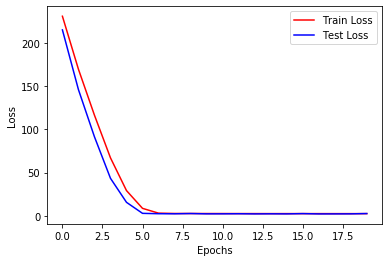

In [73]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss, 'r')
plt.plot(epochs, test_loss, 'b')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# y_pred = model_nn.predict(X_test, batch_size=128, verbose=1)